In [1]:
!gdown "1xsW8Lq33lhWaVc4Q_O1zOdy1_siXX1QW"

Downloading...
From: https://drive.google.com/uc?id=1xsW8Lq33lhWaVc4Q_O1zOdy1_siXX1QW
To: /ssd_scratch/cvit/sashank.sridhar/Conditionally/data.zip
100%|██████████████████████████████████████| 11.6M/11.6M [00:00<00:00, 31.6MB/s]


In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/sentences.txt      
  inflating: data/strokes.npy        


In [3]:
import numpy as np
import torch
import os
import time
import matplotlib.pyplot as plt 

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data


In [4]:
strokes = np.load('data/strokes.npy', encoding='latin1', allow_pickle=True)
with open('data/sentences.txt') as f:
    texts = f.readlines()
    
train_strokes = []
train_texts = []
validation_strokes = []
validation_texts = []

# only train data with length at most 800
for _ in range(len(strokes)):
    if len(strokes[_]) <= 801:
        train_strokes.append(strokes[_])
        train_texts.append(texts[_])
    else:
        validation_strokes.append(strokes[_])
        validation_texts.append(texts[_])

# pad with zeros and build masks
train_masks = np.zeros((len(train_strokes),800))
for i in range(len(train_strokes)):
    train_masks[i][0:len(train_strokes[i])-1] = 1
    train_strokes[i] = np.vstack([train_strokes[i], np.zeros((801-len(train_strokes[i]), 3))])
    
validation_masks = np.zeros((len(validation_strokes),1200))
for i in range(len(validation_strokes)):
    validation_masks[i][0:len(validation_strokes[i])-1] = 1
    validation_strokes[i] = np.vstack([validation_strokes[i], np.zeros((1201-len(validation_strokes[i]), 3))])

np.save('data/train_strokes_800', np.stack(train_strokes))
np.save('data/train_masks_800', train_masks)
np.save('data/validation_strokes_800', np.stack(validation_strokes))
np.save('data/validation_masks_800', validation_masks)

# convert each text sentence to an array of onehots
char_list = ' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,."\'?-'

char_to_code = {}
code_to_char = {}
c = 0
for _ in char_list:
    char_to_code[_] = c
    code_to_char[c] = _
    c += 1
torch.save(char_to_code, 'char_to_code.pt')

max_text_len = np.max(np.array([len(a) for a in validation_texts]))

train_onehot_800 = []
train_text_masks = []
for t in train_texts:
    onehots = np.zeros((max_text_len, len(char_to_code)+1))
    mask = np.ones(max_text_len)
    for _ in range(len(t)):
        try:
            onehots[_][char_to_code[t[_]]] = 1
        except:
            onehots[_][-1] = 1
    mask[len(t):] = 0
    train_onehot_800.append(onehots)
    train_text_masks.append(mask)
train_onehot_800 = np.stack(train_onehot_800)
train_text_masks = np.stack(train_text_masks)
train_text_lens = np.array([[len(a)] for a in train_texts])

validation_onehot_800 = []
validation_text_masks = []
for t in validation_texts:
    onehots = np.zeros((max_text_len, len(char_to_code)+1))
    mask = np.ones(max_text_len)
    for _ in range(len(t)):
        try:
            onehots[_][char_to_code[t[_]]] = 1
        except:
            onehots[_][-1] = 1
    mask[len(t):] = 0
    validation_onehot_800.append(onehots)
    validation_text_masks.append(mask)
validation_onehot_800 = np.stack(validation_onehot_800)
validation_text_masks = np.stack(validation_text_masks)
validation_text_lens = np.array([[len(a)] for a in validation_texts])

np.save('data/train_onehot_800', train_onehot_800)
np.save('data/validation_onehot_800', validation_onehot_800)
np.save('data/train_text_masks', train_text_masks)
np.save('data/validation_text_masks', validation_text_masks)
np.save('data/train_text_lens', train_text_lens)
np.save('data/validation_text_lens', validation_text_lens)

In [5]:
cuda = torch.cuda.is_available()

In [6]:
class LSTMRandWriter(nn.Module):
    def __init__(self, cell_size, num_clusters):
        super(LSTMRandWriter, self).__init__()
        
        self.lstm = nn.LSTM(input_size = 3, hidden_size = cell_size,\
                                num_layers = 1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size = cell_size+3, \
                                hidden_size = cell_size,\
                                num_layers = 1, batch_first=True)
        self.linear1 = nn.Linear(cell_size*2,\
                                    1+ num_clusters*6)
        self.tanh = nn.Tanh()
        
    def forward(self, x, prev, prev2):
        h1, (h1_n, c1_n) = self.lstm(x, prev)
        
        x2 = torch.cat([h1, x], dim=-1) # skip connection
        h2, (h2_n, c2_n) = self.lstm2(x2, prev2)
        
        h = torch.cat([h1, h2], dim=-1) # skip connection
        params = self.linear1(h)

        
        mog_params = params.narrow(-1, 0, params.size()[-1]-1)
        pre_weights, mu_1, mu_2, log_sigma_1, log_sigma_2, pre_rho = mog_params.chunk(6, dim=-1)
        weights = F.softmax(pre_weights, dim=-1)
        rho = self.tanh(pre_rho)
        end = F.sigmoid(params.narrow(-1, params.size()[-1]-1, 1))
        
        return end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2,\
            rho, (h1_n, c1_n), (h2_n, c2_n)

In [7]:
# attention window for handwriting synthesis
class Window(nn.Module):
    def __init__(self, padded_text_len, cell_size, K):
        super(Window, self).__init__()
        self.linear = nn.Linear(cell_size, 3*K)
        self.padded_text_len = padded_text_len
        
    def forward(self, x, kappa_old, onehots, text_lens):
        params = self.linear(x).exp()
        
        alpha, beta, pre_kappa = params.chunk(3, dim=-1)
        kappa = kappa_old + pre_kappa
        
        indices = torch.from_numpy(np.array(range(self.padded_text_len + 1))).type(torch.FloatTensor)
        if cuda:
            indices = indices.cuda()
        indices = Variable(indices, requires_grad=False)
        gravity = -beta.unsqueeze(2)*(kappa.unsqueeze(2).repeat(1, 1, self.padded_text_len + 1)-indices)**2
        phi = (alpha.unsqueeze(2) * gravity.exp()).sum(dim=1)*(self.padded_text_len/text_lens)
        
        w = (phi.narrow(-1, 0, self.padded_text_len).unsqueeze(2) * onehots).sum(dim=1) 
        return w, kappa, phi

In [8]:
class LSTM1(nn.Module):
    def __init__(self, padded_text_len, vocab_len, cell_size, K):
        super(LSTM1, self).__init__()
        self.lstm = nn.LSTMCell(input_size = 3 + vocab_len, hidden_size = cell_size)
        self.window = Window(padded_text_len, cell_size, K)
        
    def forward(self, x, onehots, text_lens, w_old, kappa_old, prev):
        h1s = []
        ws = []
        phis = []
        for _ in range(x.size()[1]):

            cell_input = torch.cat([x.narrow(1,_,1).squeeze(1),w_old], dim=-1)
            prev = self.lstm(cell_input, prev)
            
            # attention window parameters
            w_old, kappa_old, old_phi = self.window(prev[0], kappa_old, onehots, text_lens)
            
            # concatenate for single pass through the next layer
            h1s.append(prev[0])
            ws.append(w_old)
        
        return torch.stack(ws, dim=0).permute(1,0,2), torch.stack(h1s, dim=0).permute(1,0,2), \
                prev, w_old, kappa_old, old_phi 
    

In [9]:
class LSTM2(nn.Module):
    def __init__(self, vocab_len, cell_size):
        super(LSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=3 + vocab_len + cell_size, 
                            hidden_size = cell_size, num_layers = 1, batch_first =True)
        
    def forward(self, x, ws, h1s, prev2):
        lstm_input = torch.cat([x,ws,h1s], -1)
        h2s, prev2 = self.lstm(lstm_input, prev2)
        return h2s, prev2

In [10]:
# 2-layer lstm with mixture of gaussian parameters as outputs
# with skip connections
class LSTMSynthesis(nn.Module):
    def __init__(self, padded_text_len, vocab_len, cell_size, num_clusters, K):
        super(LSTMSynthesis, self).__init__()
        self.lstm1 = LSTM1(padded_text_len, vocab_len, cell_size, K)
        self.lstm2 = LSTM2(vocab_len, cell_size)
        self.linear = nn.Linear(cell_size*2, 1+ num_clusters*6)
        self.tanh = nn.Tanh()
        
    def forward(self, x, onehots, text_lens, w_old, kappa_old, prev, prev2, bias=0.):
        ws, h1s, prev, w_old, kappa_old, old_phi = self.lstm1(x, onehots, text_lens, w_old, kappa_old, prev)
        h2s, prev2 = self.lstm2(x, ws, h1s, prev2)
        
        params = self.linear(torch.cat([h1s,h2s], dim=-1))
        mog_params = params.narrow(-1, 0, params.size()[-1]-1)
        pre_weights, mu_1, mu_2, log_sigma_1, log_sigma_2, pre_rho = mog_params.chunk(6, dim=-1)
        weights = F.softmax(pre_weights*(1+bias), dim=-1)
        rho = self.tanh(pre_rho)
        end = F.sigmoid(params.narrow(-1, params.size()[-1]-1, 1))
        
        return end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, w_old, kappa_old, prev, prev2, old_phi

In [11]:
def decay_learning_rate(optimizer, decay_rate):
    # learning rate annealing
    state_dict = optimizer.state_dict()
    lr = state_dict['param_groups'][0]['lr']
    lr *= decay_rate
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    return optimizer

In [12]:
def save_checkpoint(epoch, model, validation_loss, optimizer, directory, \
                    filename='best.pt'):
    checkpoint=({'epoch': epoch+1,
    'model': model.state_dict(),
    'validation_loss': validation_loss,
    'optimizer' : optimizer.state_dict()
    })
    try:
        torch.save(checkpoint, os.path.join(directory, filename))
        
    except:
        os.mkdir(directory)
        torch.save(checkpoint, os.path.join(directory, filename))


In [13]:
def plot_stroke(stroke, save_name=None):
    # Plot a single example.
    f, ax = plt.subplots()

    x = np.cumsum(stroke[:, 1])
    y = np.cumsum(stroke[:, 2])

    size_x = x.max() - x.min() + 1.
    size_y = y.max() - y.min() + 1.

    f.set_size_inches(5. * size_x / size_y, 5.)

    cuts = np.where(stroke[:, 0] == 1)[0]
    start = 0

    for cut_value in cuts:
        ax.plot(x[start:cut_value], y[start:cut_value],
                'k-', linewidth=3)
        start = cut_value + 1
    ax.axis('equal')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if save_name is None:
        plt.show()
    else:
        try:
            plt.savefig(
                save_name,
                bbox_inches='tight',
                pad_inches=0.5)
        except Exception:
            print ("Error building image!: " + save_name)

    plt.close()

In [14]:
# training objective
def log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, \
                    y, masks):
    # targets
    y_0 = y.narrow(-1,0,1)
    y_1 = y.narrow(-1,1,1)
    y_2 = y.narrow(-1,2,1)
    
    # end of stroke prediction
    end_loglik = (y_0*end + (1-y_0)*(1-end)).log().squeeze()
    
    # new stroke point prediction
    const = 1E-20 # to prevent numerical error
    pi_term = torch.Tensor([2*np.pi])
    if cuda:
        pi_term = pi_term.cuda()
    pi_term = -Variable(pi_term, requires_grad = False).log()
    
    z = (y_1 - mu_1)**2/(log_sigma_1.exp()**2)\
        + ((y_2 - mu_2)**2/(log_sigma_2.exp()**2)) \
        - 2*rho*(y_1-mu_1)*(y_2-mu_2)/((log_sigma_1 + log_sigma_2).exp())
    mog_lik1 =  pi_term -log_sigma_1 - log_sigma_2 - 0.5*((1-rho**2).log())
    mog_lik2 = z/(2*(1-rho**2))
    mog_loglik = ((weights.log() + (mog_lik1 - mog_lik2)).exp().sum(dim=-1)+const).log()
    
    return (end_loglik*masks).sum() + ((mog_loglik)*masks).sum()

In [15]:
def synthesis_train(args, train_loader, validation_loader):
    # infer padded text len and vocab len
    padded_text_len, vocab_len = train_loader.dataset[0][2].size()
    
    # define model and optimizer
    model = LSTMSynthesis(padded_text_len, vocab_len, args['cell_size'], args['num_clusters'], args['K'])
    if cuda:
        model = model.cuda()
    
    optimizer = optim.Adam([{'params':model.parameters()},], lr=args['learning_rate'])
    
    # initialize null hidden, memory states and cluster centers
    h1_init = c1_init = torch.zeros((args['batch_size'], args['cell_size']))
    h2_init = c2_init = torch.zeros((1, args['batch_size'], args['cell_size']))
    kappa_old = torch.zeros(args['batch_size'], args['K'])
    
    if cuda:
        h1_init, c1_init = h1_init.cuda(), c1_init.cuda()
        h2_init, c2_init = h2_init.cuda(), c2_init.cuda()
        kappa_old = kappa_old.cuda()
        
    h1_init, c1_init = Variable(h1_init, requires_grad=False), Variable(c1_init, requires_grad=False)
    h2_init, c2_init = Variable(h2_init, requires_grad=False), Variable(c2_init, requires_grad=False)
    kappa_old = Variable(kappa_old, requires_grad=False)
    
    t_loss = []
    v_loss = []
    best_validation_loss = 1E10
    
    # training
    start_time = time.time()
    for epoch in range(args['num_epochs']):
        train_loss =0
        for batch_idx, (data, masks, onehots, text_lens) in enumerate(train_loader):
            
            # gather training batch
            step_back = data.narrow(1,0,args['timesteps'])
            x = Variable(step_back, requires_grad=False)
            onehots = Variable(onehots, requires_grad = False)
            masks = Variable(masks, requires_grad=False)
            masks = masks.narrow(1,0,args['timesteps'])
            text_lens = Variable(text_lens, requires_grad=False)
            
            # focus window weight on first text char
            w_old = onehots.narrow(1,0,1).squeeze()
            
            optimizer.zero_grad()
            
            # feed forward
            outputs = model(x,onehots, text_lens, w_old, kappa_old, (h1_init, c1_init), (h2_init, c2_init))
            end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, w, kappa, prev, prev2, old_phi = outputs
            data = data.narrow(1,1,args['timesteps'])
            y = Variable(data, requires_grad=False)
            loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, y, masks)/torch.sum(masks)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()))
    
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch+1, train_loss/(len(train_loader.dataset)//args['batch_size'])))
        t_loss.append(train_loss/(len(train_loader.dataset)//args['batch_size']))
    
        # validation
        # prepare validation data
        (validation_samples, masks, onehots, text_lens) = list(enumerate(validation_loader))[0][1]
        step_back = validation_samples.narrow(1,0,args['timesteps'])
        masks = Variable(masks, requires_grad=False)
        masks = masks.narrow(1,0,args['timesteps'])
        onehots = Variable(onehots, requires_grad=False)
        text_lens = Variable(text_lens, requires_grad=False)
        
        w_old = onehots.narrow(1,0,1).squeeze()
        x = Variable(step_back, requires_grad=False)
        
        validation_samples = validation_samples.narrow(1,1,args['timesteps'])
        y = Variable(validation_samples, requires_grad = False)
    
        outputs = model(x, onehots, text_lens, w_old, kappa_old, (h1_init, c1_init), (h2_init, c2_init))
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, w, kappa, prev, prev2, old_phi = outputs
        loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, y, masks)/torch.sum(masks)
        validation_loss = loss.item()
        print('====> Epoch: {} Average validation loss: {:.4f}'.format(\
            epoch+1, validation_loss))
        v_loss.append(validation_loss)
    
        
        # # learning rate annealing
        # if (epoch+1)%10 == 0:
        #     optimizer = decay_learning_rate(optimizer)
        
        # checkpoint model and training
        filename = args['task'] + '_epoch_{}.pt'.format(epoch+1)
        save_checkpoint(epoch, model, validation_loss, optimizer, args['model_dir'], filename)
        
        print('wall time: {}s'.format(time.time()-start_time))
        
    f1 = plt.figure(1)
    plt.plot(range(1, args['num_epochs']+1), t_loss, color='blue', linestyle='solid')
    plt.plot(range(1, args['num_epochs']+1), v_loss, color='red', linestyle='solid')
    f1.savefig(args['task'] +"_loss_curves", bbox_inches='tight')
    

In [16]:
args = {}
args['task'] = 'synthesis'
args['cell_size'] = 400
args['batch_size'] = 50
args['timesteps'] = 800
args['num_epochs'] = 50
args['model_dir'] = 'save'
args['learning_rate'] = 8E-4
args['decay_rate'] = 0.99
args['num_clusters'] = 20
args['K'] = 20

In [17]:
train_data = [np.load('data/train_strokes_800.npy'), np.load('data/train_masks_800.npy'), np.load('data/train_onehot_800.npy'),
                np.load('data/train_text_lens.npy')]

In [18]:
for _ in range(len(train_data)):
        train_data[_] =torch.from_numpy(train_data[_]).type(torch.FloatTensor)
        if cuda:
            train_data[_] = train_data[_].cuda()

In [19]:
train_data = [(train_data[0][i], train_data[1][i], 
                train_data[2][i], train_data[3][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=args['batch_size'], shuffle=True, drop_last=True)

In [20]:
validation_data = [np.load('data/validation_strokes_800.npy'), np.load('data/validation_masks_800.npy'), 
                    np.load('data/validation_onehot_800.npy'), np.load('data/validation_text_lens.npy')]
for _ in range(len(validation_data)):
    validation_data[_] = torch.from_numpy(validation_data[_]).type(torch.FloatTensor)
    if cuda:
        validation_data[_] = validation_data[_].cuda()
validation_data = [(validation_data[0][i], validation_data[1][i], validation_data[2][i], validation_data[3][i]) 
                for i in range(len(validation_data[0]))] 
validation_loader = torch.utils.data.DataLoader(
    validation_data, batch_size=args['batch_size'], shuffle=False, drop_last=True)

/home2/sashank.sridhar/miniconda3/envs/TripletLoss/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/4977 (0%)]	Loss: 4.556543
Train Epoch: 1 [500/4977 (10%)]	Loss: 2.914186
Train Epoch: 1 [1000/4977 (20%)]	Loss: 2.812930
Train Epoch: 1 [1500/4977 (30%)]	Loss: 2.826246
Train Epoch: 1 [2000/4977 (40%)]	Loss: 2.587486
Train Epoch: 1 [2500/4977 (51%)]	Loss: 2.200056
Train Epoch: 1 [3000/4977 (61%)]	Loss: 1.787325
Train Epoch: 1 [3500/4977 (71%)]	Loss: 1.378647
Train Epoch: 1 [4000/4977 (81%)]	Loss: 1.030092
Train Epoch: 1 [4500/4977 (91%)]	Loss: 0.876814
====> Epoch: 1 Average train loss: 2.1414
====> Epoch: 1 Average validation loss: 0.4021
wall time: 114.05437898635864s
Train Epoch: 2 [0/4977 (0%)]	Loss: 0.809524
Train Epoch: 2 [500/4977 (10%)]	Loss: 0.897870
Train Epoch: 2 [1000/4977 (20%)]	Loss: 0.746667
Train Epoch: 2 [1500/4977 (30%)]	Loss: 0.736921
Train Epoch: 2 [2000/4977 (40%)]	Loss: 0.668248
Train Epoch: 2 [2500/4977 (51%)]	Loss: 0.636920
Train Epoch: 2 [3000/4977 (61%)]	Loss: 0.509773
Train Epoch: 2 [3500/4977 (71%)]	Loss: 0.490124
Train Epoch: 2 [4000/4977 

Train Epoch: 14 [4500/4977 (91%)]	Loss: 0.138780
====> Epoch: 14 Average train loss: 0.0548
====> Epoch: 14 Average validation loss: -0.4047
wall time: 1609.4874033927917s
Train Epoch: 15 [0/4977 (0%)]	Loss: 0.020593
Train Epoch: 15 [500/4977 (10%)]	Loss: 0.018112
Train Epoch: 15 [1000/4977 (20%)]	Loss: 0.045228
Train Epoch: 15 [1500/4977 (30%)]	Loss: -0.029493
Train Epoch: 15 [2000/4977 (40%)]	Loss: -0.055458
Train Epoch: 15 [2500/4977 (51%)]	Loss: 0.084180
Train Epoch: 15 [3000/4977 (61%)]	Loss: 0.017243
Train Epoch: 15 [3500/4977 (71%)]	Loss: 0.028643
Train Epoch: 15 [4000/4977 (81%)]	Loss: -0.039126
Train Epoch: 15 [4500/4977 (91%)]	Loss: 0.046945
====> Epoch: 15 Average train loss: 0.0340
====> Epoch: 15 Average validation loss: -0.4482
wall time: 1724.2178814411163s
Train Epoch: 16 [0/4977 (0%)]	Loss: 0.008547
Train Epoch: 16 [500/4977 (10%)]	Loss: 0.108094
Train Epoch: 16 [1000/4977 (20%)]	Loss: 0.011423
Train Epoch: 16 [1500/4977 (30%)]	Loss: -0.035508
Train Epoch: 16 [2000/497

Train Epoch: 28 [1000/4977 (20%)]	Loss: 0.451446
Train Epoch: 28 [1500/4977 (30%)]	Loss: 0.402816
Train Epoch: 28 [2000/4977 (40%)]	Loss: 0.392351
Train Epoch: 28 [2500/4977 (51%)]	Loss: 0.322281
Train Epoch: 28 [3000/4977 (61%)]	Loss: 0.371765
Train Epoch: 28 [3500/4977 (71%)]	Loss: 0.391027
Train Epoch: 28 [4000/4977 (81%)]	Loss: 0.314722
Train Epoch: 28 [4500/4977 (91%)]	Loss: 0.395815
====> Epoch: 28 Average train loss: 0.3764
====> Epoch: 28 Average validation loss: -0.1455
wall time: 3219.487847328186s
Train Epoch: 29 [0/4977 (0%)]	Loss: 0.292911
Train Epoch: 29 [500/4977 (10%)]	Loss: 0.396078
Train Epoch: 29 [1000/4977 (20%)]	Loss: 0.364565
Train Epoch: 29 [1500/4977 (30%)]	Loss: 0.325419
Train Epoch: 29 [2000/4977 (40%)]	Loss: 0.307071
Train Epoch: 29 [2500/4977 (51%)]	Loss: 0.278637
Train Epoch: 29 [3000/4977 (61%)]	Loss: 0.279326
Train Epoch: 29 [3500/4977 (71%)]	Loss: 0.321351
Train Epoch: 29 [4000/4977 (81%)]	Loss: 0.410274
Train Epoch: 29 [4500/4977 (91%)]	Loss: 0.367783
=

Train Epoch: 41 [4500/4977 (91%)]	Loss: 0.137804
====> Epoch: 41 Average train loss: 0.1251
====> Epoch: 41 Average validation loss: -0.3558
wall time: 4740.067611217499s
Train Epoch: 42 [0/4977 (0%)]	Loss: 0.034845
Train Epoch: 42 [500/4977 (10%)]	Loss: 0.113422
Train Epoch: 42 [1000/4977 (20%)]	Loss: 0.162848
Train Epoch: 42 [1500/4977 (30%)]	Loss: 0.120060
Train Epoch: 42 [2000/4977 (40%)]	Loss: 0.104378
Train Epoch: 42 [2500/4977 (51%)]	Loss: 0.021528
Train Epoch: 42 [3000/4977 (61%)]	Loss: 0.100538
Train Epoch: 42 [3500/4977 (71%)]	Loss: 0.141493
Train Epoch: 42 [4000/4977 (81%)]	Loss: 0.215145
Train Epoch: 42 [4500/4977 (91%)]	Loss: 0.146952
====> Epoch: 42 Average train loss: 0.1082
====> Epoch: 42 Average validation loss: -0.3363
wall time: 4843.881251811981s
Train Epoch: 43 [0/4977 (0%)]	Loss: 0.162088
Train Epoch: 43 [500/4977 (10%)]	Loss: 0.032233
Train Epoch: 43 [1000/4977 (20%)]	Loss: 0.094111
Train Epoch: 43 [1500/4977 (30%)]	Loss: 0.056549
Train Epoch: 43 [2000/4977 (40%

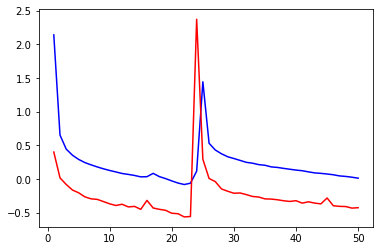

In [21]:
if args['task'] == 'synthesis':
        synthesis_train(args, train_loader, validation_loader)

In [22]:
def attention_plot(phis):
    plt.rcParams["figure.figsize"] = (12,6)
    phis= phis/(np.sum(phis, axis = 0, keepdims=True))
    plt.xlabel('handwriting generation')
    plt.ylabel('text scanning')
    plt.imshow(phis, cmap='hot', interpolation='nearest', aspect='auto')
    plt.show()

In [31]:
def generate_conditionally(text, cell_size=400, num_clusters=20, K=20, random_state=700, \
                            bias=1., bias2=1., state_dict_file='save/synthesis_epoch_50.pt'):
    
    char_to_code = torch.load('char_to_code.pt')
    np.random.seed(random_state)
    text = text + ' '
    
    model = LSTMSynthesis(len(text), len(char_to_code)+1, cell_size, num_clusters, K)
    model.load_state_dict(torch.load(state_dict_file)['model'])
    
    onehots = np.zeros((len(text), len(char_to_code)+1))
    for _ in range(len(text)):
        try:
            onehots[_][char_to_code[text[_]]] = 1
        except:
            onehots[_][-1] = 1
    
    zero_tensor = torch.zeros((1,1,3))
    h1_init, c1_init = torch.zeros((1,cell_size)), torch.zeros((1,cell_size))
    h2_init, c2_init = torch.zeros((1,1,cell_size)), torch.zeros((1,1,cell_size))
    kappa_old = torch.zeros(1, K)
    onehots = torch.from_numpy(onehots).type(torch.FloatTensor)
    text_len = torch.from_numpy(np.array([[len(text)]])).type(torch.FloatTensor)
    
    if cuda:
        model.cuda()
        zero_tensor = zero_tensor.cuda()
        h1_init, c1_init = h1_init.cuda(), c1_init.cuda()
        h2_init, c2_init = h2_init.cuda(), c2_init.cuda()
        kappa_old = kappa_old.cuda()
        onehots = onehots.cuda()
        text_len = text_len.cuda()
        
    x = Variable(zero_tensor)
    h1_init, c1_init = Variable(h1_init), Variable(c1_init)
    h2_init, c2_init = Variable(h2_init), Variable(c2_init)
    prev = (h1_init, c1_init)
    prev2 = (h2_init, c2_init)
    kappa_old = Variable(kappa_old)
    onehots = Variable(onehots, requires_grad = False)
    w_old = onehots.narrow(0,0,1)  # attention on the first input text char
    text_len = Variable(text_len)
    
    record = [np.zeros(3)]
    phis = []
    stop = False
    count = 0
    while not stop:    
        outputs = model(x, onehots, text_len, w_old, kappa_old, prev, prev2, bias)
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, rho, w_old, kappa_old, prev, prev2, old_phi = outputs
        
        #bernoulli sample
        prob_end = end.data[0][0][0]
        sample_end = np.random.binomial(1,prob_end.item())

        #mog sample
        sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index].item(), mu_2.data[0][0][sample_index].item()])
        log_sigma_1 = log_sigma_1 - bias2
        log_sigma_2 = log_sigma_2 - bias2
        v1 = (log_sigma_1).exp().data[0][0][sample_index]**2
        v2 = (log_sigma_2).exp().data[0][0][sample_index]**2
        c = rho.data[0][0][sample_index]*log_sigma_1.exp().data[0][0][sample_index]\
            *log_sigma_2.exp().data[0][0][sample_index]
        cov = np.array([[v1.item(),c.item()],[c.item(),v2.item()]])
        sample_point = np.random.multivariate_normal(mu, cov)
        
        out = np.insert(sample_point,0,sample_end)
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view(1,1,3)
        
        # attention
        old_phi = old_phi.squeeze(0)
        phis.append(old_phi)
        old_phi = old_phi.data.cpu().numpy()
        
        # hack to prevent early exit (attention is unstable at the beginning)
        if count >=20 and np.max(old_phi) == old_phi[-1]:
            stop = True
        count += 1
        
    phis = torch.stack(phis).data.cpu().numpy().T
         
    plot_stroke(np.array(record))
    attention_plot(phis)


/home2/sashank.sridhar/miniconda3/envs/TripletLoss/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


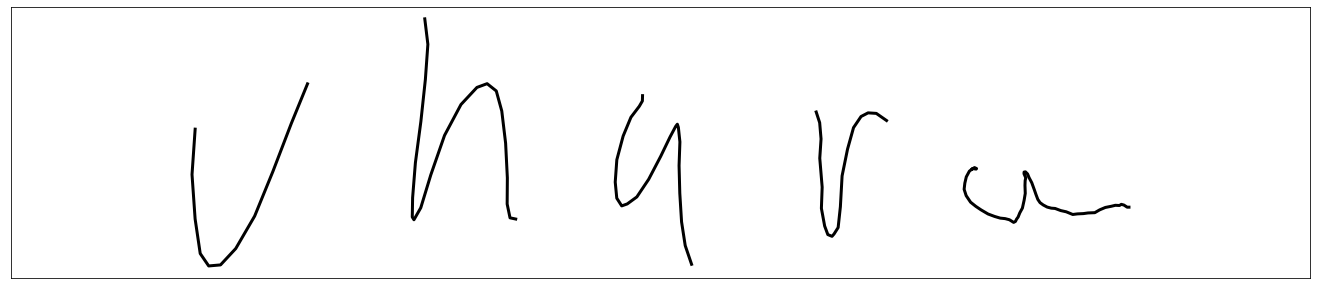

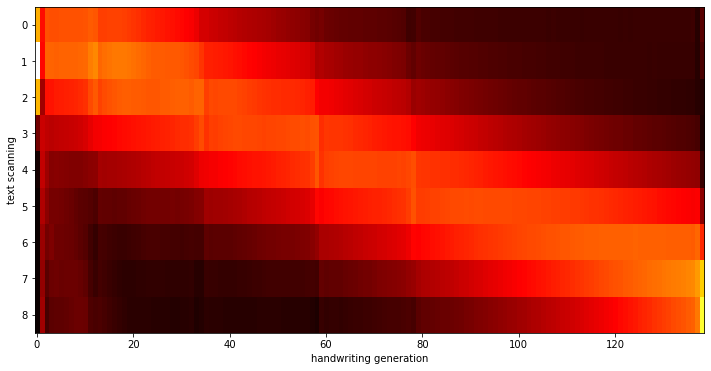

In [35]:
generate_conditionally('weights')